# Tổng quan

Vì dữ liệu 191GB nên em up sample dataset với 30 ảnh lên để tổng quan về dữ liệu trước.
Download tại [link](https://drive.google.com/drive/folders/1xEcsZFq596lOIqejHgZTmNRs_SMdGnd4?usp=sharing)


Dữ liệu được lưu dưới định dạng DICOM

Tập train với 15,000 ảnh

Tập public test với 3,000 ảnh

Ảnh được gắn với 14 nhãn:

0 - Aortic enlargement

1 - Atelectasis

2 - Calcification

3 - Cardiomegaly

4 - Consolidation

5 - ILD

6 - Infiltration

7 - Lung Opacity

8 - Nodule/Mass

9 - Other lesion

10 - Pleural effusion

11 - Pleural thickening

12 - Pneumothorax

13 - Pulmonary fibrosis

14 - "No finding" observation was intended to capture the absence of all findings above

**Ở đây nhãn được gắn bởi nhiều chuyên gia X quang, nghĩa là một ảnh sẽ có nhiều ground-truth!**

## Dữ liệu mẫu

Mô tả dữ liệu:

train.csv: metadata của tập train, với mỗi hàng là một mẫu ảnh, bao gồm tên nhãn và bounding box (một ảnh có thể có nhiều hàng)

![figures](figures/overview_data.PNG)

Các cột trong train.csv

- image_id: tên dữ liệu
- class_name: tên của nhãn có trong ảnh (nêu không có thì hiện "No finding")
- class_id: ID của nhãn có trong ảnh (từ 0 đến 14)
- rad_id: ID của chuyên gia X quang, người gắn nhãn
- x_min: minimum X coordinate of the object's bounding box
- y_min: minimum Y coordinate of the object's bounding box
- x_max: maximum X coordinate of the object's bounding box
- y_max: maximum Y coordinate of the object's bounding box

sample_submission.csv: sample submission file in the correct format

**Đầu ra của bài toán là một model có thể khoanh vùng và phân loại 14 loại bất thường trong ảnh**

Tìm hiểu sâu về 14 loại bất thường có thể tham khảo repo sau:

[https://www.kaggle.com/sakuraandblackcat/chest-x-ray-knowledges-for-the-14-abnormalities](https://www.kaggle.com/sakuraandblackcat/chest-x-ray-knowledges-for-the-14-abnormalities)


## Visualize dữ liệu

#### Import libraries

In [1]:
import os
from tqdm import tqdm
import sys
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from random import randint
import cv2

import pydicom
# remember to install : pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg
# follow: https://pydicom.github.io/pydicom/dev/tutorials/installation.html
from pydicom.pixel_data_handlers.util import apply_voi_lut

from skimage import exposure
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

#### Setup global variables

In [2]:
DATA_DIR = "E:/Kaggle/VinBigData/"

# Define the paths to the training and testing dicom folders respectively
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

In [3]:
# Capture all the relevant full train/test paths
TRAIN_DICOM_PATHS = [os.path.join(TRAIN_DIR, f_name) for f_name in os.listdir(TRAIN_DIR)]
TEST_DICOM_PATHS = [os.path.join(TEST_DIR, f_name) for f_name in os.listdir(TEST_DIR)]
print("The number of training files is {}".format(len(TRAIN_DICOM_PATHS)))
print("The number of testing files is {}".format(len(TEST_DICOM_PATHS)))

The number of training files is 15000
The number of testing files is 3000


In [4]:
# Define paths to the relevant csv files
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
SS_CSV = os.path.join(DATA_DIR, "sample_submission.csv")

In [5]:
# Create the relevant dataframe objects
train_df = pd.read_csv(TRAIN_CSV)
# Create 'rad_label" -> multi groundtruth
le = preprocessing.LabelEncoder()
train_df['rad_label'] = le.fit_transform(train_df['rad_id'])

ss_df = pd.read_csv(SS_CSV)

## Tìm hiểu về định dạng DICOM?

Tham khảo tại: https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data

In [6]:
test_dicom = pydicom.read_file(TRAIN_DICOM_PATHS[2])

In [7]:
test_dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 154
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 0005e8e3701dfb1dd93d53e2ff537b6e
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's Age                       AS: '028Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0008) Number of Frames                    IS: "1"
(0028, 0010) Rows                                US: 3072
(0028, 0011) Columns                   

### Chuyển từ định dạng DICOM về np.array cần lưu ý:

Source: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way

"you must consider, that raw dicom data is not actually linearly convertable to "human-friendly" png/jpg. In fact, most of DICOM's store pixel values in exponential scale, which is resolved by standard standard DICOM viewers.

So in order to get jpg/png as radiologists would initially see in their workspace, you need to apply some transformations. DICOM metadata stores information how to make such "human-friendly" transformations."

In [8]:
# dicom2array
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data

In [9]:
img = dicom2array(TRAIN_DICOM_PATHS[1])

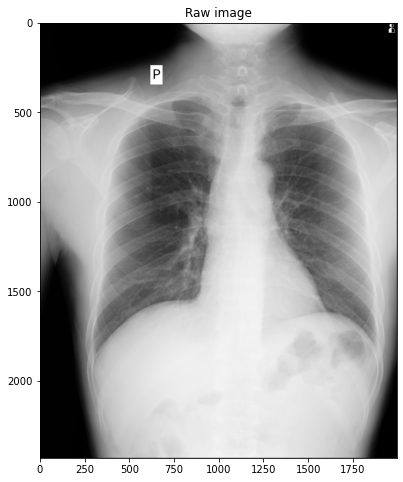

In [10]:
plt.figure(figsize = (8,8))
plt.imshow(img, 'gray')
plt.title('Raw image')
plt.show()

## Some normalization techniques

Source: https://www.kaggle.com/raddar/popular-x-ray-image-normalization-techniques

### Histogram normalization

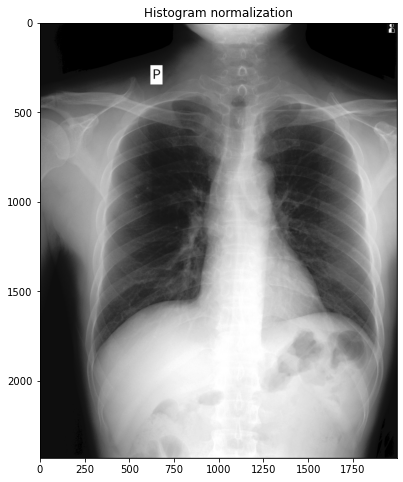

In [11]:
img_histogram_normalize = exposure.equalize_hist(img)

plt.figure(figsize = (8,8))
plt.imshow(img_histogram_normalize, 'gray')
plt.title('Histogram normalization')
plt.show()

### CLAHE normalization

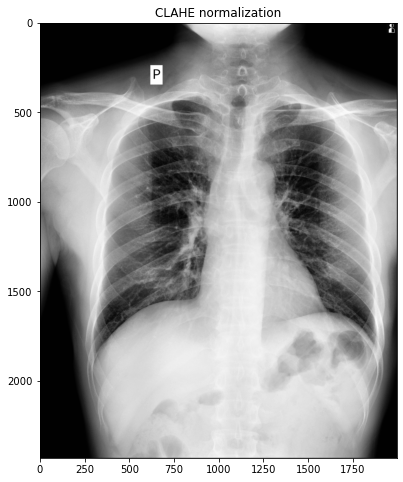

In [12]:
img_clahe_normalization = exposure.equalize_adapthist(img/np.max(img))

plt.figure(figsize = (8,8))
plt.imshow(img_clahe_normalization, 'gray')
plt.title('CLAHE normalization')
plt.show()

## Plot with bounding box

Bounding box coordinates

![figure](figures/bbox.PNG)

In [13]:
def get_bbox_area(row):
    return (row['x_max']-row['x_min'])*(row['y_max']-row['y_min'])

def get_bbox_df():
    bbox_df = train_df[train_df['class_name'] != 'No finding']
    bbox_df['bbox_area'] = bbox_df.apply(get_bbox_area, axis=1)
    return bbox_df

In [14]:
bbox_df = get_bbox_df()
bbox_df.head()

image_id          class_name  class_id rad_id  \
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
5  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening        11     R9   
6  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD         5    R17   
7  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass         8     R9   

    x_min   y_min   x_max   y_max  rad_label  bbox_area  
2   691.0  1375.0  1653.0  1831.0          1   438672.0  
3  1264.0   743.0  1611.0  1019.0          1    95772.0  
5   627.0   357.0   947.0   433.0         16    24320.0  
6  1347.0   245.0  2188.0  2169.0          8  1618084.0  
7   557.0  2352.0   675.0  2484.0         16    15576.0

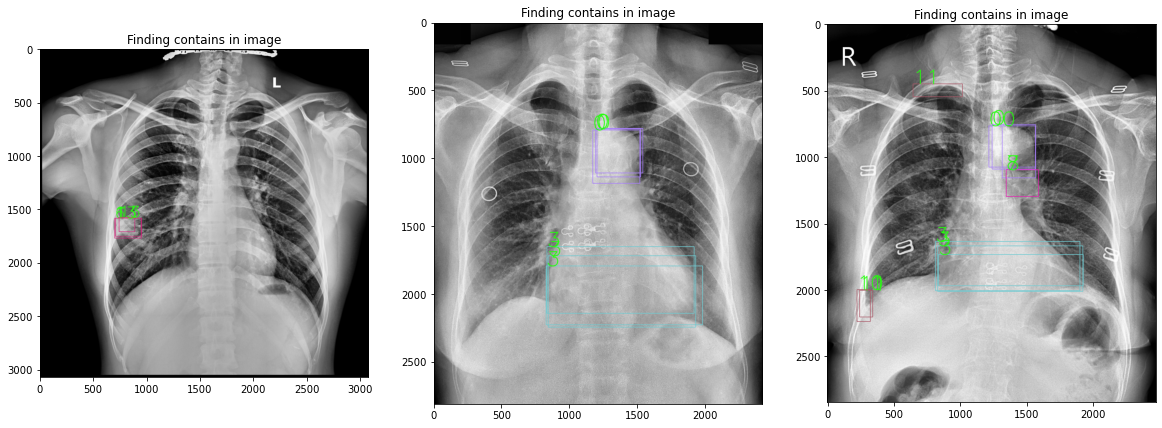

In [15]:
def plot_bbox(num_visualize = 5, bbox_df = bbox_df):

    img_ids = bbox_df['image_id'].values

    class_ids = bbox_df['class_id'].unique()
    
    label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}

    plt.figure(figsize=(20,8))
    sub_num =1
    for i in range(num_visualize):
        img_id = random.choice(img_ids)
        img_path = os.path.join(TRAIN_DIR, img_id + ".dicom")
        img = dicom2array(img_path)

        # normalize
        img = exposure.equalize_adapthist(img/np.max(img))
        img = (img * 255).astype(np.uint8)

        # --- Convert from single-channel grayscale to 3-channel RGB
        img = np.stack([img] * 3, axis=2)

        # add bounding boxes
        box_coordinates = bbox_df.loc[bbox_df['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values
        labels = bbox_df.loc[bbox_df['image_id'] == img_id, ['class_id']].values.squeeze()
        for label_id, box in zip(labels, box_coordinates):
            color = label2color[label_id]
            img_bbox = cv2.rectangle(
                img,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                color = color, thickness= 3
            )
            # add labels
            cv2.putText(img_bbox, str(label_id), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 5, (36,255,12), 5)

        plt.subplot(1,3,sub_num)
        sub_num += 1
        plt.imshow(img_bbox, cmap = 'gray')
        plt.title('Finding contains in image')
    plt.show()
plot_bbox(num_visualize = 3)

## Explore features distribution

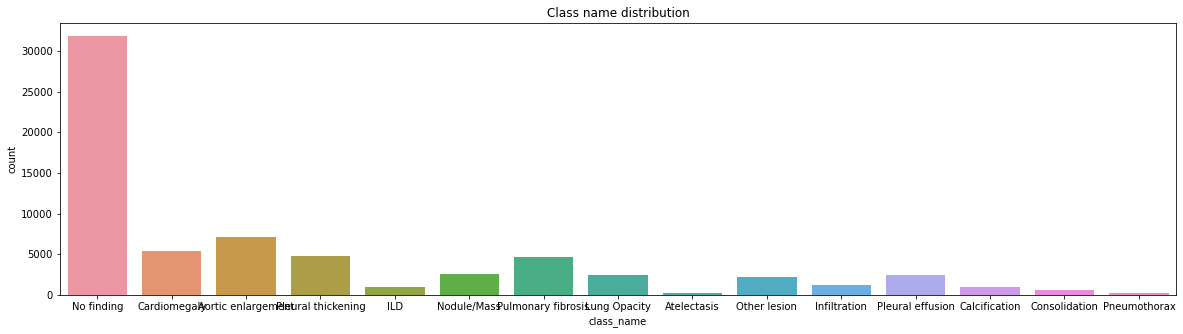

In [16]:
plt.figure(figsize=(20,5))
sns.countplot(x = 'class_name', data = train_df)
plt.title('Class name distribution')
plt.show()


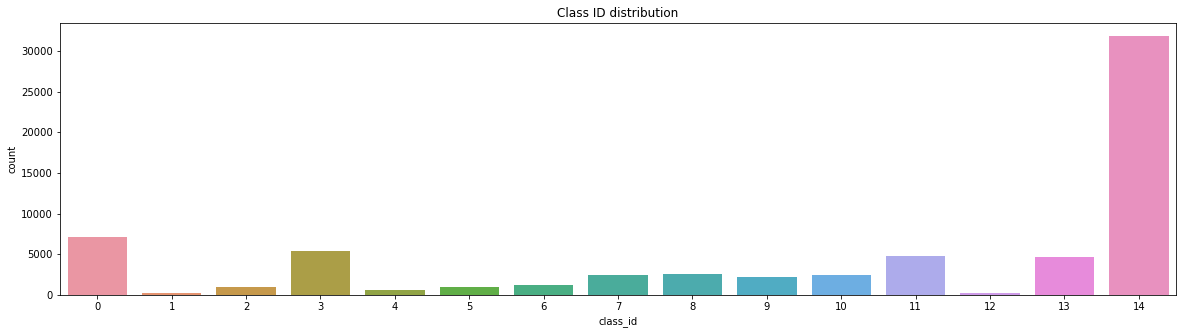

In [17]:
plt.figure(figsize=(20,5))
sns.countplot(x = 'class_id', data = train_df)
plt.title('Class ID distribution')
plt.show()


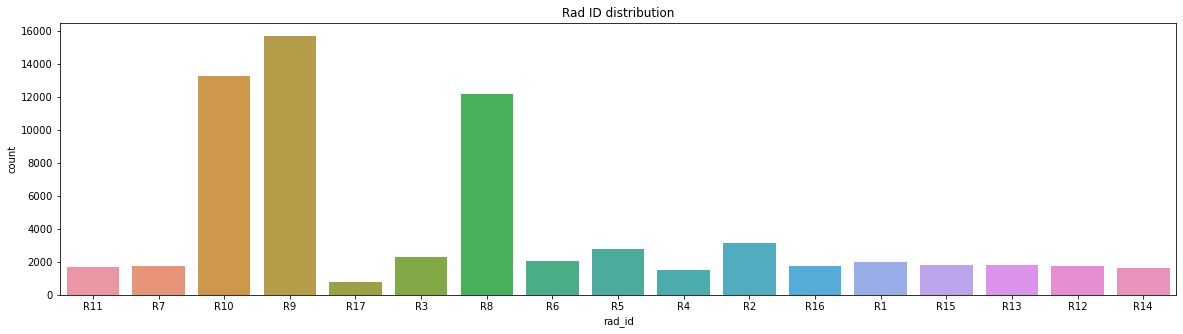

In [18]:
plt.figure(figsize=(20,5))
sns.countplot(x = 'rad_id', data = train_df)
plt.title('Rad ID distribution')
plt.show()

## [Dive deep into 14 abnormalities](https://www.kaggle.com/sakuraandblackcat/chest-x-ray-knowledges-for-the-14-abnormalities)

In [20]:
def get_bbox_df_abnormality(id):
    bbox_df_abnormality = train_df[train_df['class_id'] == id]
    return bbox_df_abnormality

### No finding - Normal condition

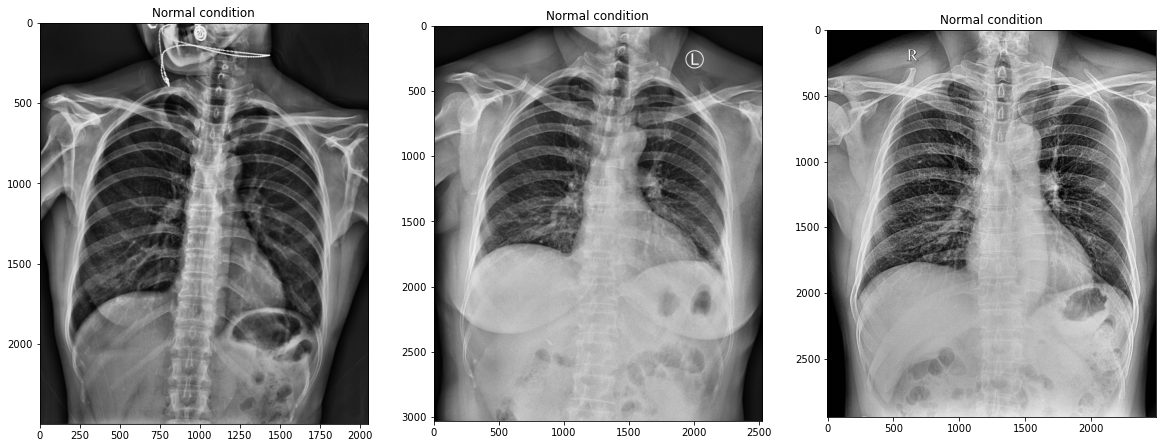

In [22]:
bbox_df_normal_condition = get_bbox_df_abnormality(id = 14)
def plot_normal_condition(num_visualize = 3, bbox_df = bbox_df_normal_condition):

    img_ids = bbox_df['image_id'].values

    class_ids = bbox_df['class_id'].unique()

    label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}

    plt.figure(figsize=(20,8))
    sub_num =1
    for i in range(num_visualize):
        img_id = random.choice(img_ids)
        img_path = os.path.join(TRAIN_DIR, img_id + ".dicom")
        img = dicom2array(img_path)

        # normalize
        img = exposure.equalize_adapthist(img/np.max(img))
        img = (img * 255).astype(np.uint8)

        # --- Convert from single-channel grayscale to 3-channel RGB
        img = np.stack([img] * 3, axis=2)

        plt.subplot(1,3,sub_num)
        sub_num += 1
        plt.imshow(img, cmap = 'gray')
        plt.title('Normal condition')
    plt.show()
plot_normal_condition()

### 0 - Aortic enlargement
- Aortic enlargement is known as a sign of an aortic aneurysm. Prone to occur in the ascending aorta.

- In general, the term aneurysm is used when the axial diameter is >5.0 cm for the ascending aorta and >4.0 cm for the descending aorta.
(Please compare the below images to the normal images.)

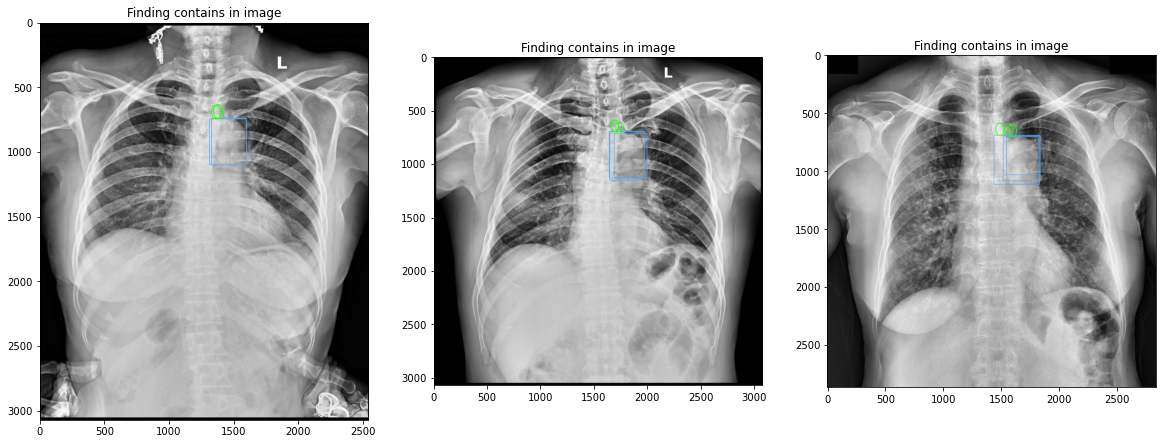

In [87]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 0)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 1 - Atelectasis
- Atelectasis is a condition where there is no air in part or all of the lungs. And the lungs are collapsed. A common cause of atelectasis is obstruction of the bronchi.
- In atelectasis, there is an increase in density on chest x-ray (usually whiter; black on black-and-white inversion images).

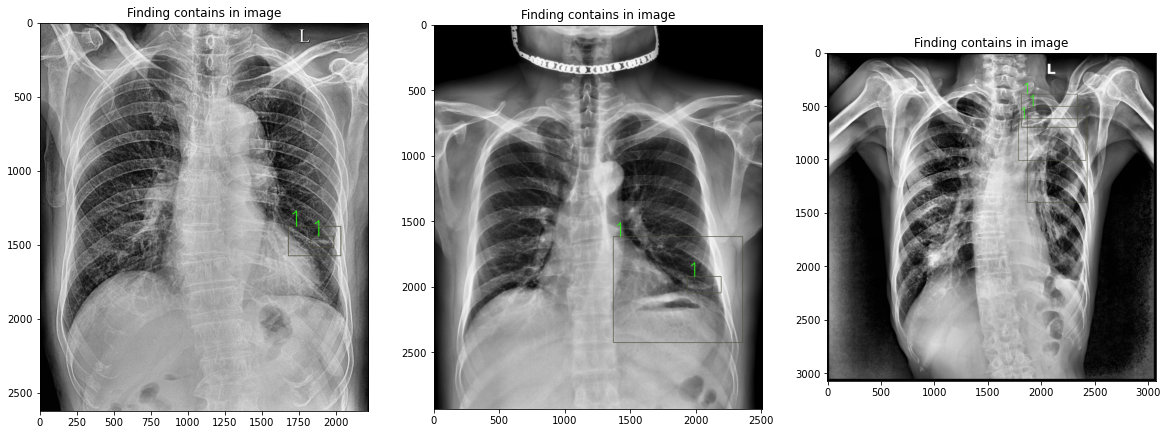

In [89]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 1)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 2 - Calcification
- Many diseases or conditions can cause calcification on chest x-ray. Calcium (calcification) may be deposited in areas where previous inflammation of the lungs or pleura has healed. Calcium may be deposited in the aorta due to atherosclerosis. Or calcification may occur in mediastinal lymph nodes.
- The image is characterized by a density similar to that of bone.

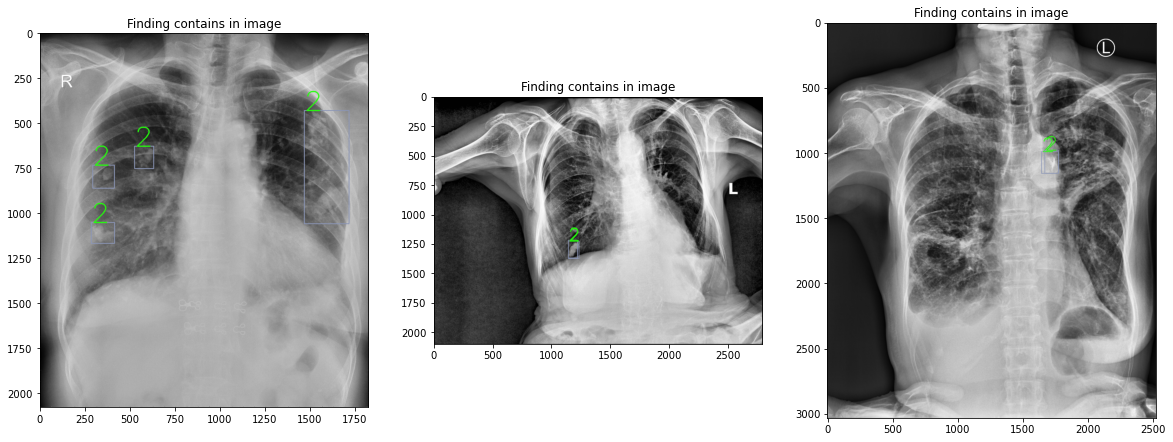

In [90]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 2)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 3 - Cardiomegaly
- Cardiomegaly can be caused by many conditions, including hypertension, coronary artery disease, infections, inherited disorders, and cardiomyopathies.
- Cardiomegaly is usually diagnosed when the ratio of the heart's width to the width of the chest is more than 50%. This diagnostic criterion may be an essential basis for this competition.
- " Comment from readers
For the criterion heart-to-lung ratio > 0.5 for the diagnosis of cardiomegaly.
This is only valid if the X-ray is performed while the patient is standing. If the patient is sitting or in bed, this criterion cannot be used. An essential point to know it is to detect air in the stomach: if there is no air in it, the patient is not standing."

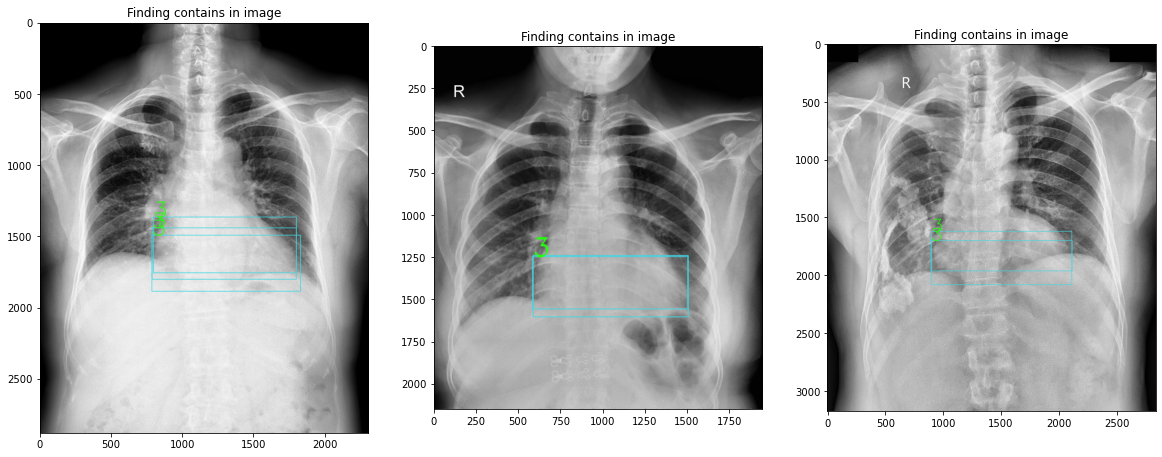

In [91]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 3)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 4 - Consolidation
- Consolidation is officially referred to as air space consolidation. It is a decrease in lung permeability due to infiltration of fluid, cells, or tissue replacing the air-containing spaces in the alveoli.
- On X-rays, the lung field's density is increased, and pulmonary blood vessels are not seen, but black bronchi can be seen in the white background, which is called "air bronchogram." Since air remains in the bronchial tubes, they do not absorb X-rays and appear black, and the black and white are reversed from normal lung fields.

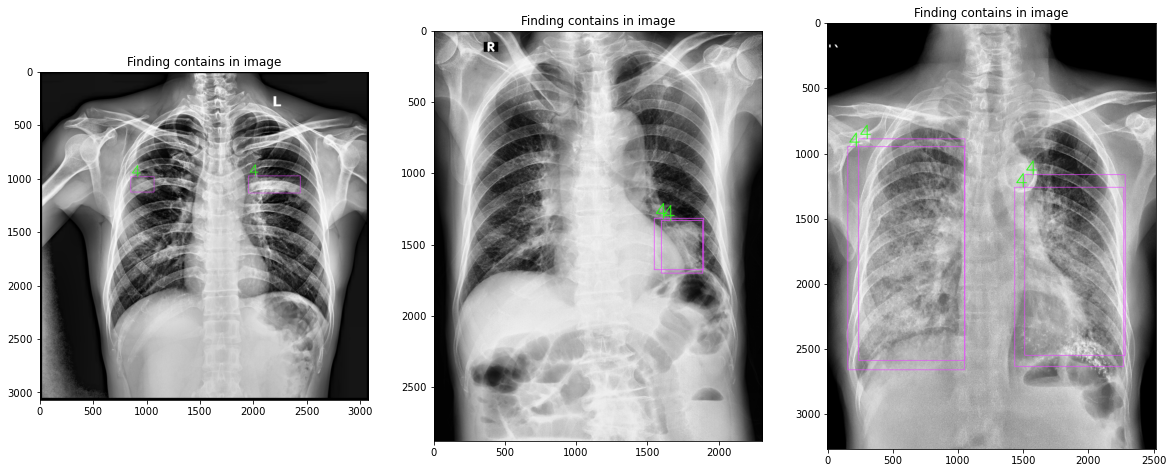

In [93]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 4)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 5 - ILD
- ILD stands for "Interstitial Lung Disease". Interstitial lung disease is a general term for many conditions in which the interstitial space is injured. The interstitial space refers to the walls of the alveoli (air sacs in the lungs) and the space around the blood vessels and small airways.
- Chest radiographic findings include ground-glass opacities (i.e., an area of hazy opacification), linear reticular shadows, and granular shadows.

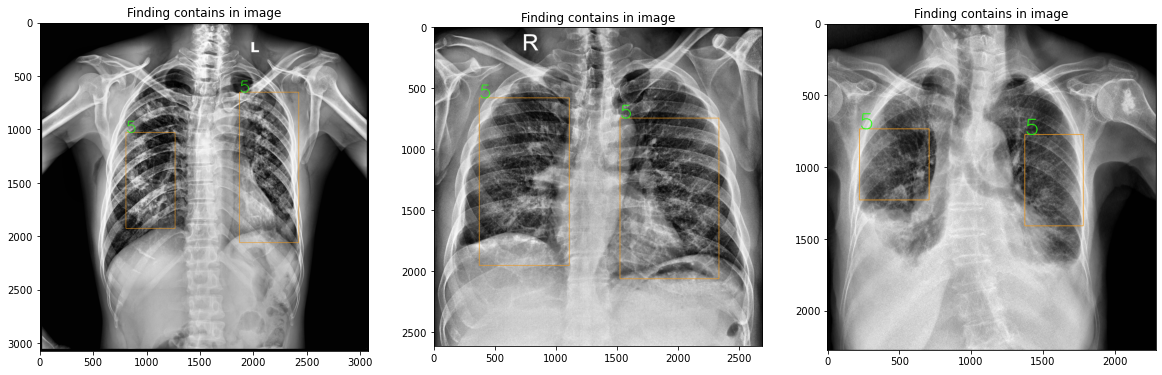

In [94]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 5)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 6 - Infiltration
- The infiltration of some fluid component into the alveoli causes an infiltrative shadow (Infiltration).
- It is difficult to distinguish from consolidation and, in some cases, impossible to distinguish.
Please see https://allnurses.com/consolidation-vs-infiltrate-vs-opacity-t483538/.

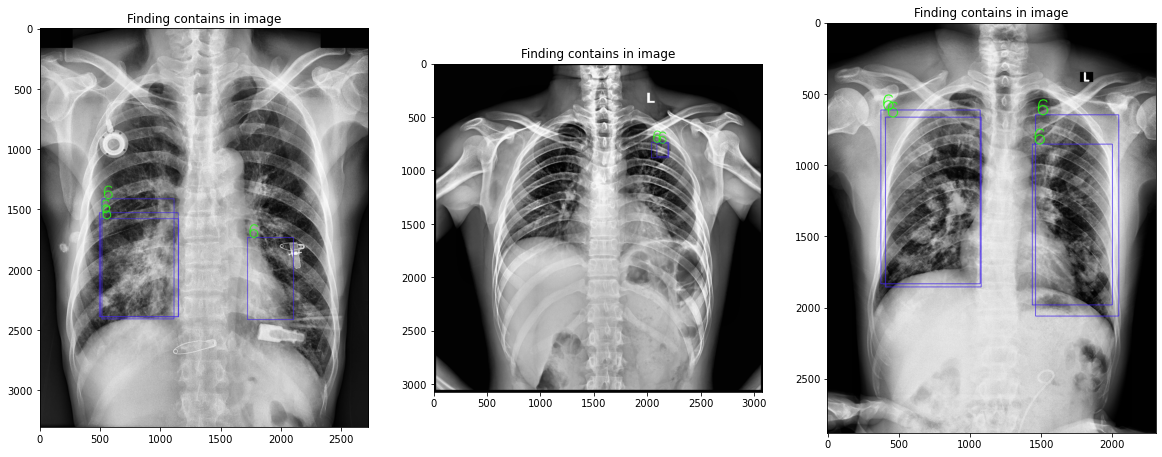

In [97]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 6)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 7 - Lung opacity
- Lung opacity is defined as any area in the chest radiograph that is more white than it should be.
Lung opacity is a loose term. Please see https://www.kaggle.com/zahaviguy/what-are-lung-opacities.
- It is difficult to distinguish from infiltration or consolidation and, in some cases, impossible to distinguish. Please see https://allnurses.com/consolidation-vs-infiltrate-vs-opacity-t483538/.

- (Infiltration, consolidation, and opacity will vary depending on who labels them, so I personally question how meaningful it is to distinguish and predict them accurately.)

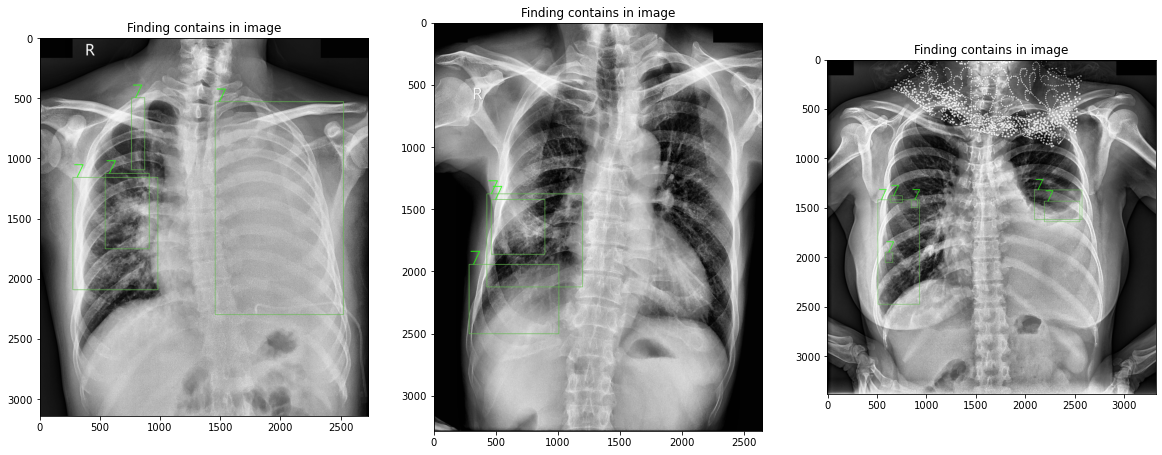

In [102]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 7)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 8 - Nodule/ Mass
- A nodule/mass is a round shade (typically less than 3 cm in diameter) that appears on a chest X-ray image.
- t can be seen in primary lung cancer, metastasis from other parts of the body such as colon cancer and kidney cancer, tuberculosis, pulmonary mycosis, non-tuberculous mycobacterium, obsolete pneumonia, and benign tumors.

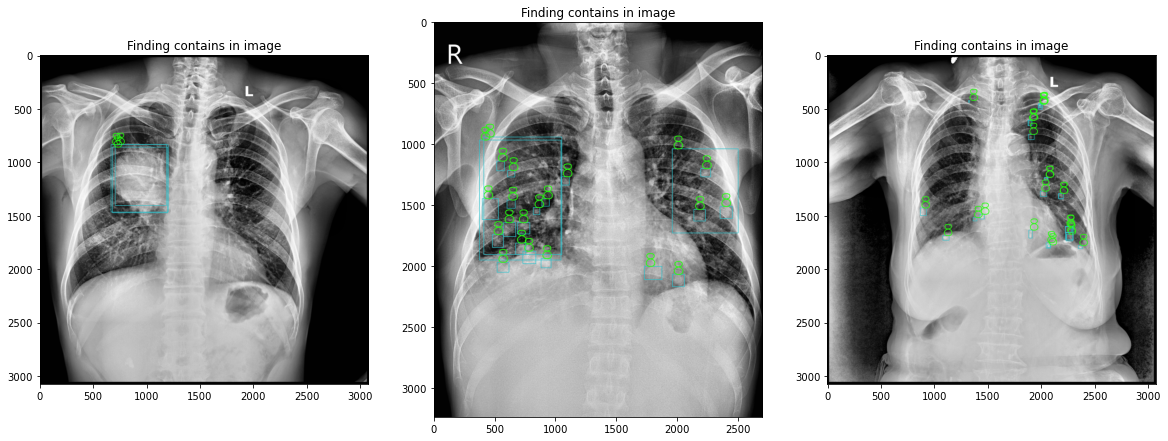

In [101]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 8)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 9 - Other lesion
- Others include all abnormalities that do not fall into any other category. This includes bone penetrating images, fractures, and subcutaneous emphysema, etc.

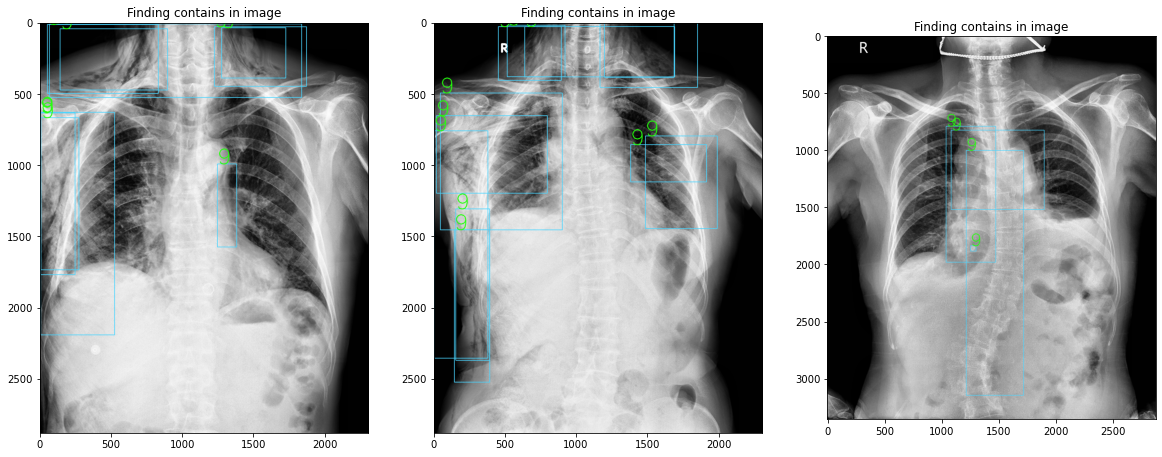

In [104]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 9)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 10 - Pleural effusion
- Pleural effusion is the accumulation of water outside the lungs in the chest cavity. The lungs are located in the chest cavity surrounded by the chest wall. The outside of the lungs is covered by a thin membrane called the pleura. The pleura consists of two layers, one on the chest wall (parietal pleura) and the other covering the lungs (visceral pleura). The fluid that accumulates between these layers is called pleural effusion.
- The findings of pleural effusion vary widely. They also vary depending on whether the radiograph is taken in the upright or supine position.
The most common findings are as follows. Elevation of the diaphragm on one side, flattening the diaphragm, or blunting the angle between rib and diaphragm (typically more than 30 degrees).

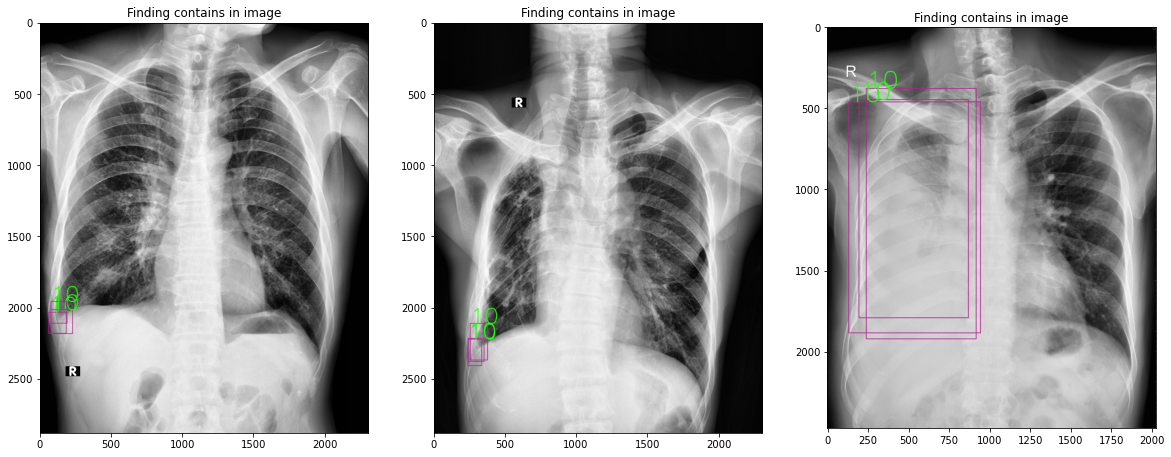

In [105]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 10)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 11 - Pleural thickening
- The pleura is the membrane that covers the lungs, and the change in the thickness of the pleura is called pleural thickening. It is often seen in the uppermost part of the lung field (the apex of the lung).
- "It typically involves the apex of the lung, which is called ‘pulmonary apical cap’. On chest X-rays, the apical cap is an irregular density located at the extreme apex and is less than 5 mm in width".
Saito, A. et al. Pleural thickening on screening chest X-rays: a single institutional study. Respir Res 20, 138 (2019). https://doi.org/10.1186/s12931-019-1116-9

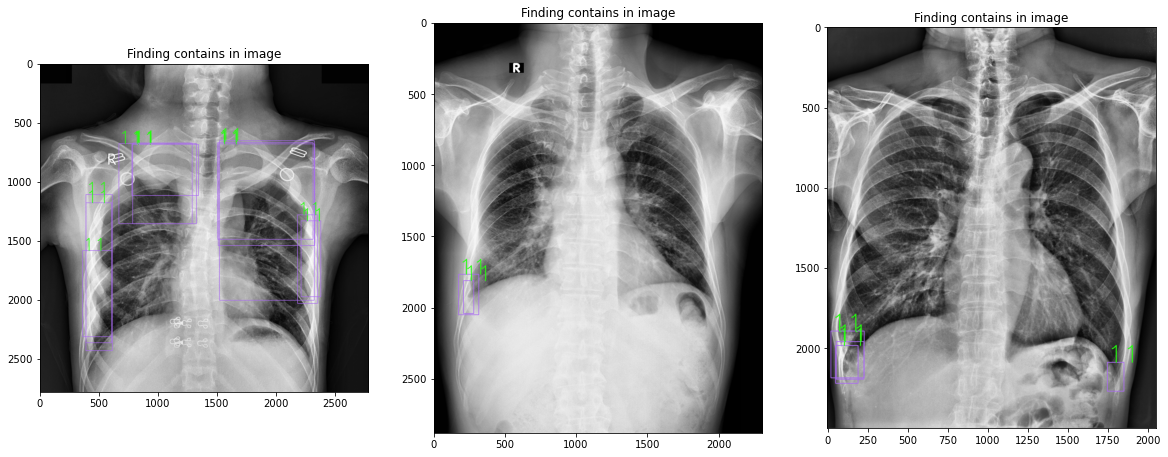

In [106]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 11)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 12 - Pneumothorax
- A pneumothorax is a condition in which air leaks from the lungs and accumulates in the chest cavity. When air leaks and accumulates in the chest, it cannot expand outward like a balloon due to the ribs' presence. Instead, the lungs are pushed by the air and become smaller. In other words, a pneumothorax is a situation where air leaks from the lungs and the lungs become smaller (collapsed).
- In a chest radiograph of a pneumothorax, the collapsed lung is whiter than normal, and the area where the lung is gone is uniformly black. Besides, the edges of the lung may appear linear.

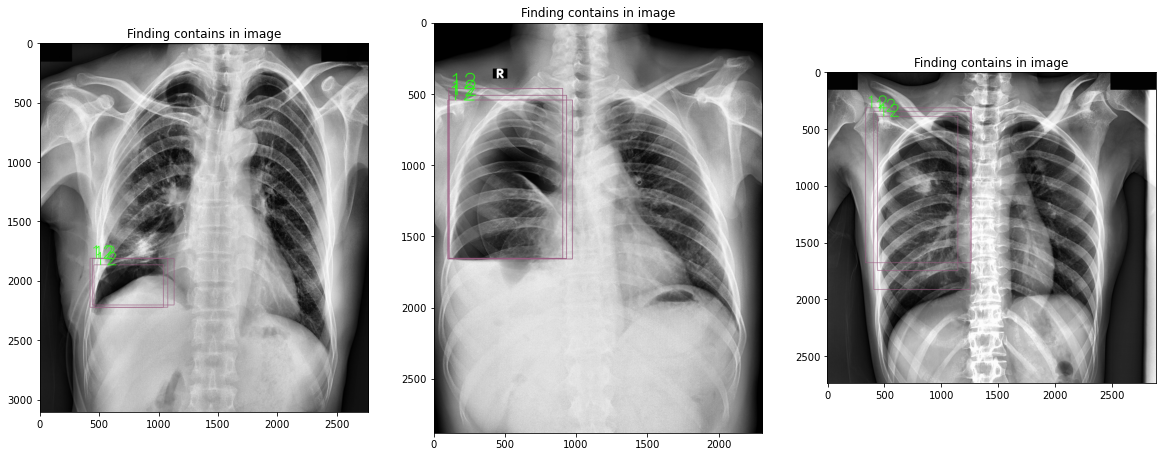

In [110]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 12)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

### 13 - Pulmonary fibrosis
- Inflammation of the lung interstitium due to various causes, resulting in thickening and hardening of the walls, fibrosis, and scarring.
- The fibrotic areas lose their air content, which often results in dense cord shadows or granular shadows.

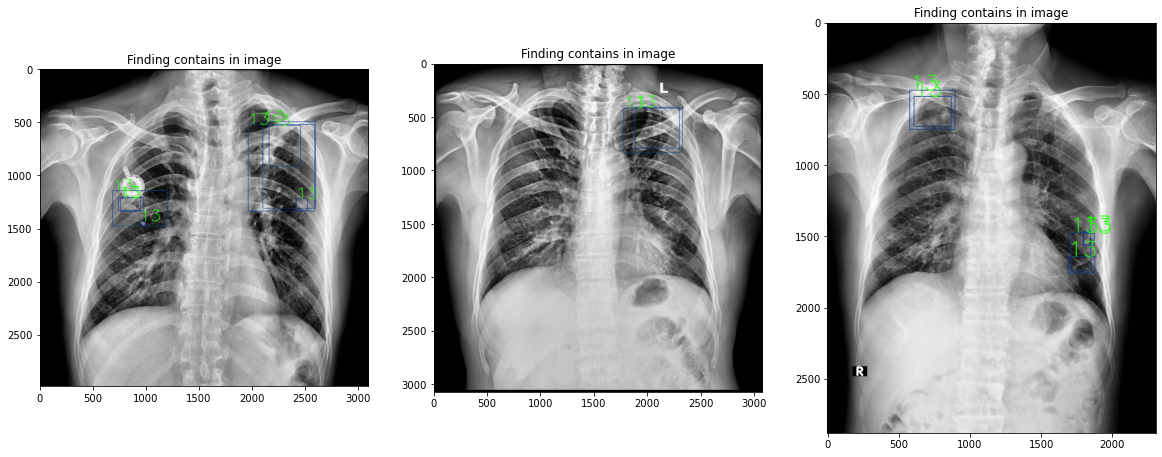

In [111]:
bbox_df_abnormality = get_bbox_df_abnormality(id = 13)
plot_bbox(num_visualize = 3, bbox_df = bbox_df_abnormality)

****

### Tổng hợp code từ sources:
1. https://www.kaggle.com/dschettler8845/visual-in-depth-eda-vinbigdata-competition-data
2. https://www.kaggle.com/sakuraandblackcat/chest-x-ray-knowledges-for-the-14-abnormalities
3. https://www.kaggle.com/trungthanhnguyen0502/eda-vinbigdata-chest-x-ray-abnormalities